# Analyze entropy vs hidden sizefor MLPs with the FFOOM dataset
Figure 6b (Appendix B.1) at time of publication.

In [1]:
%load_ext lab_black
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from typing import List, Tuple
import seaborn as sns
import sys
import wandb
import matplotlib as mpl
from matplotlib import cm, font_manager as fm, pyplot as plt

### Preamble
Paths, plotting style, colors, and WandB stuff

In [2]:
# Plot formatting
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

try:
    # Set the font properties globally
    font_path = "./fonts/cmunbx.otf"
    font_prop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=font_prop.get_name())
except:
    print("Unable to set font to Computer Modern (cmunbx.otf)")

In [3]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "analyze_ffoom_entropy.ipynb"
)
SAVE_DIR = "../data/FFOOM/"
entity, PROJECT_NAME = "kdu", "bauer-ffoom"  # set to your entity and project
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_ffoom_entropy_and_grad_{datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis"],
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


{}


In [4]:
api = wandb.Api()
runs = api.runs(entity + "/" + PROJECT_NAME)
summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    if "analysis" not in run.tags:
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)

In [5]:
def convert_dict_to_df(df, col_name):
    return df[col_name].apply(lambda row: pd.Series(row))

In [6]:
expanded_df = pd.concat(
    [
        convert_dict_to_df(runs_df, "summary"),
        convert_dict_to_df(runs_df, "config"),
        convert_dict_to_df(
            convert_dict_to_df(runs_df, "config"), "DATASET_KWARGS_IDENTIFIABLE"
        ),
        runs_df[["name"]],
    ],
    axis=1,
)

/tmp/ipykernel_198644/1335290998.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return df[col_name].apply(lambda row: pd.Series(row))
/tmp/ipykernel_198644/1335290998.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return df[col_name].apply(lambda row: pd.Series(row))
/tmp/ipykernel_198644/1335290998.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return df[col_name].apply(lambda row: pd.Series(row))
/tmp/ipykernel_198644/1335290998.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return df[col_name].apply(lamb

In [7]:
valid_hidden_szs = set([4, 8, 16, 32, 64, 128])
valid_num_points = set([1000, 5000, 10000, 20000])
right_cutoff_timestamp = datetime.fromisoformat("2022-11-11T23:59:59")

In [8]:
expanded_df = expanded_df[expanded_df["entropy"].notna()]
expanded_df = expanded_df[expanded_df["grads_per_input_feature"].notna()]
expanded_df = expanded_df[expanded_df["HIDDEN_SIZE"].isin(valid_hidden_szs)]
expanded_df = expanded_df[expanded_df["PM_RUN_ID"].notna()]
expanded_df = expanded_df[
    expanded_df["_timestamp"].apply(datetime.fromtimestamp) < right_cutoff_timestamp
]

In [9]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 368 to 439
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   strata_2                         0 non-null      object 
 1   strata_9                         0 non-null      object 
 2   unregularized_loss               0 non-null      float64
 3   sample_inds_for_validation       0 non-null      object 
 4   _step                            72 non-null     float64
 5   _wandb                           72 non-null     object 
 6   entropy                          72 non-null     float64
 7   strata_0                         0 non-null      object 
 8   all                              0 non-null      object 
 9   epoch                            72 non-null     float64
 10  strata_1                         0 non-null      object 
 11  strata_4                         0 non-null      object 
 12  strata_5             

In [10]:
expanded_df

,strata_2,strata_9,unregularized_loss,sample_inds_for_validation,_step,_wandb,entropy,strata_0,all,epoch,...,LEARNING_RATE,DATASET_KWARGS,OVERWRITE_MODEL,TEST_BATCH_SIZE,SAMPLING_FRACTION,NUM_ELEMENTS_PER_STRATA,DATASET_KWARGS_IDENTIFIABLE,num_points,0,name
368,NaN,NaN,NaN,NaN,500.0,{'runtime': 8},5.607158,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 20000},20000.0,NaN,astral-violet-189
369,NaN,NaN,NaN,NaN,500.0,{'runtime': 8},5.018359,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 20000},20000.0,NaN,quiet-snowflake-188
370,NaN,NaN,NaN,NaN,500.0,{'runtime': 8},4.386354,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 20000},20000.0,NaN,absurd-resonance-187
371,NaN,NaN,NaN,NaN,500.0,{'runtime': 9},3.472321,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 20000},20000.0,NaN,comfy-haze-186
372,NaN,NaN,NaN,NaN,500.0,{'runtime': 8},2.946592,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 20000},20000.0,NaN,solar-sound-184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,NaN,NaN,NaN,NaN,25.0,{'runtime': 5},4.702565,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 1000},1000.0,NaN,fallen-brook-118
436,NaN,NaN,NaN,NaN,25.0,{'runtime': 5},3.922790,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 1000},1000.0,NaN,flowing-plasma-117
437,NaN,NaN,NaN,NaN,25.0,{'runtime': 5},3.368418,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 1000},1000.0,NaN,eager-wave-116
438,NaN,NaN,NaN,NaN,25.0,{'runtime': 5},2.303849,NaN,NaN,0.0,...,0.001,{},NaN,100.0,1.0,NaN,{'num_points': 1000},1000.0,NaN,pious-puddle-115


In [11]:
expanded_df = expanded_df[
    [
        "name",
        "entropy",
        "entropy_per_input_feature",
        "grads_per_input_feature",
        "accuracy",
        "loss",
        "HIDDEN_SIZE",
        "SEED",
        "num_points",
    ]
]

In [12]:
expanded_df = expanded_df.reset_index()
entropy_per_input_feature_df = pd.DataFrame(
    expanded_df["entropy_per_input_feature"].to_list()
).add_prefix("f")
expanded_df = pd.concat([expanded_df, entropy_per_input_feature_df], axis=1)
expanded_df = expanded_df.rename(columns={"f0": "relevant_feature"})
expanded_df["mean_irrelevant_features"] = expanded_df[["f1", "f2", "f3"]].mean(axis=1)

grads_per_input_feature_df = pd.DataFrame(
    expanded_df["grads_per_input_feature"].to_list()
).add_prefix("g")
expanded_df = pd.concat([expanded_df, grads_per_input_feature_df], axis=1)
expanded_df = expanded_df.rename(columns={"g0": "relevant_feature_grad"})
expanded_df["mean_irrelevant_features_grad"] = expanded_df[["g1", "g2", "g3"]].mean(
    axis=1
)
expanded_df

,index,name,entropy,entropy_per_input_feature,grads_per_input_feature,accuracy,loss,HIDDEN_SIZE,SEED,num_points,relevant_feature,f1,f2,f3,mean_irrelevant_features,relevant_feature_grad,g1,g2,g3,mean_irrelevant_features_grad
0,368,astral-violet-189,5.607158,"[5.759920499496052, 5.508635228046498, 5.57088...","[0.0011722803810545997, -6.629619377852836e-05...",0.98350,0.068680,128.0,5.0,20000.0,5.759920,5.508635,5.570881,5.589197,5.556238,0.001172,-0.000066,-0.000014,-0.000042,-0.000041
1,369,quiet-snowflake-188,5.018359,"[5.098936741378792, 5.0105610345065354, 4.9771...","[0.0043000411172813245, -0.0002422109867425941...",0.98300,0.082605,64.0,5.0,20000.0,5.098937,5.010561,4.977111,4.986828,4.991500,0.004300,-0.000242,-0.000078,-0.000226,-0.000182
2,370,absurd-resonance-187,4.386354,"[4.560668954549919, 4.411129858529513, 4.30001...","[0.006075090712108404, -0.0003730344687157478,...",0.97975,0.103004,32.0,5.0,20000.0,4.560669,4.411130,4.300015,4.273600,4.328248,0.006075,-0.000373,-0.000148,-0.000324,-0.000282
3,371,comfy-haze-186,3.472321,"[3.5927941076188925, 3.5240822023306064, 3.400...","[0.00047227928865074375, -0.000467506900133708...",0.94000,0.204806,16.0,5.0,20000.0,3.592794,3.524082,3.400406,3.372002,3.432164,0.000472,-0.000468,-0.000751,-0.000584,-0.000601
4,372,solar-sound-184,2.946592,"[2.7933050518964113, 2.7957126008254134, 3.146...","[-0.00633693295885914, 0.0012835882394048258, ...",0.87625,0.326881,8.0,5.0,20000.0,2.793305,2.795713,3.146017,3.051333,2.997687,-0.006337,0.001284,0.001984,0.000511,0.001260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,435,fallen-brook-118,4.702565,"[4.687726805695016, 4.767405610017447, 4.60729...","[0.0011013271391392947, -0.0016288386718628348...",0.60500,0.705981,64.0,3.0,1000.0,4.687727,4.767406,4.607290,4.747837,4.707511,0.001101,-0.001629,0.000511,-0.001944,-0.001021
68,436,flowing-plasma-117,3.922790,"[3.85709372921804, 4.009181321447091, 3.927309...","[0.0028988470460706165, -0.003302109180063414,...",0.51000,0.837079,32.0,3.0,1000.0,3.857094,4.009181,3.927310,3.897574,3.944688,0.002899,-0.003302,-0.005382,-0.000806,-0.003163
69,437,eager-wave-116,3.368418,"[3.1631669274366834, 3.36629837620817, 3.42595...","[0.0008668282704882799, -0.0004036987815881648...",0.51000,0.836681,16.0,3.0,1000.0,3.163167,3.366298,3.425960,3.518246,3.436835,0.000867,-0.000404,0.002138,0.000084,0.000606
70,438,pious-puddle-115,2.303849,"[2.164427574651054, 2.4621934289024563, 2.2444...","[-0.004326240395934529, -0.0003074244628978604...",0.49000,0.796725,8.0,3.0,1000.0,2.164428,2.462193,2.244445,2.344331,2.350323,-0.004326,-0.000307,0.000524,0.002300,0.000839


### Construct long-form datasets for entropy (per feature) and accuracy

In [13]:
expanded_df_long = pd.melt(
    expanded_df,
    id_vars=["HIDDEN_SIZE", "num_points"],
    value_vars=["relevant_feature", "mean_irrelevant_features"],
    # value_vars=["f0", "f1", "f2", "f3"],
    var_name="metric",
    value_name="entropy",
)
expanded_df_long

expanded_df_long_grads = pd.melt(
    expanded_df,
    id_vars=["HIDDEN_SIZE", "num_points"],
    value_vars=["relevant_feature_grad", "mean_irrelevant_features_grad"],
    # value_vars=["f0", "f1", "f2", "f3"],
    var_name="metric",
    value_name="grad",
)
expanded_df_long_grads

expanded_df_long_accuracy = pd.melt(
    expanded_df,
    id_vars=["HIDDEN_SIZE", "num_points"],
    value_vars=["accuracy"],
    var_name="metric",
    value_name="accuracy",
)
expanded_df_long_accuracy

expanded_df_long_accuracy = pd.melt(
    expanded_df,
    id_vars=["HIDDEN_SIZE", "num_points"],
    value_vars=["accuracy"],
    var_name="metric",
    value_name="accuracy",
)
expanded_df_long_accuracy

/tmp/ipykernel_198644/2446106376.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long = pd.melt(
/tmp/ipykernel_198644/2446106376.py:21: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long_accuracy = pd.melt(
/tmp/ipykernel_198644/2446106376.py:30: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long_accuracy = pd.melt(


,HIDDEN_SIZE,num_points,metric,accuracy
0,128.0,20000.0,accuracy,0.98350
1,64.0,20000.0,accuracy,0.98300
2,32.0,20000.0,accuracy,0.97975
3,16.0,20000.0,accuracy,0.94000
4,8.0,20000.0,accuracy,0.87625
...,...,...,...,...
67,64.0,1000.0,accuracy,0.60500
68,32.0,1000.0,accuracy,0.51000
69,16.0,1000.0,accuracy,0.51000
70,8.0,1000.0,accuracy,0.49000


In [14]:
table = wandb.Table(dataframe=expanded_df_long)
wandb.log({"relevant_runs_table_entropy": table})
accuracy_table = wandb.Table(dataframe=expanded_df_long_accuracy)
wandb.log({"relevant_runs_table_accuracy": accuracy_table})

### Plot the entropy for the relevant feature and irrelevant features

4


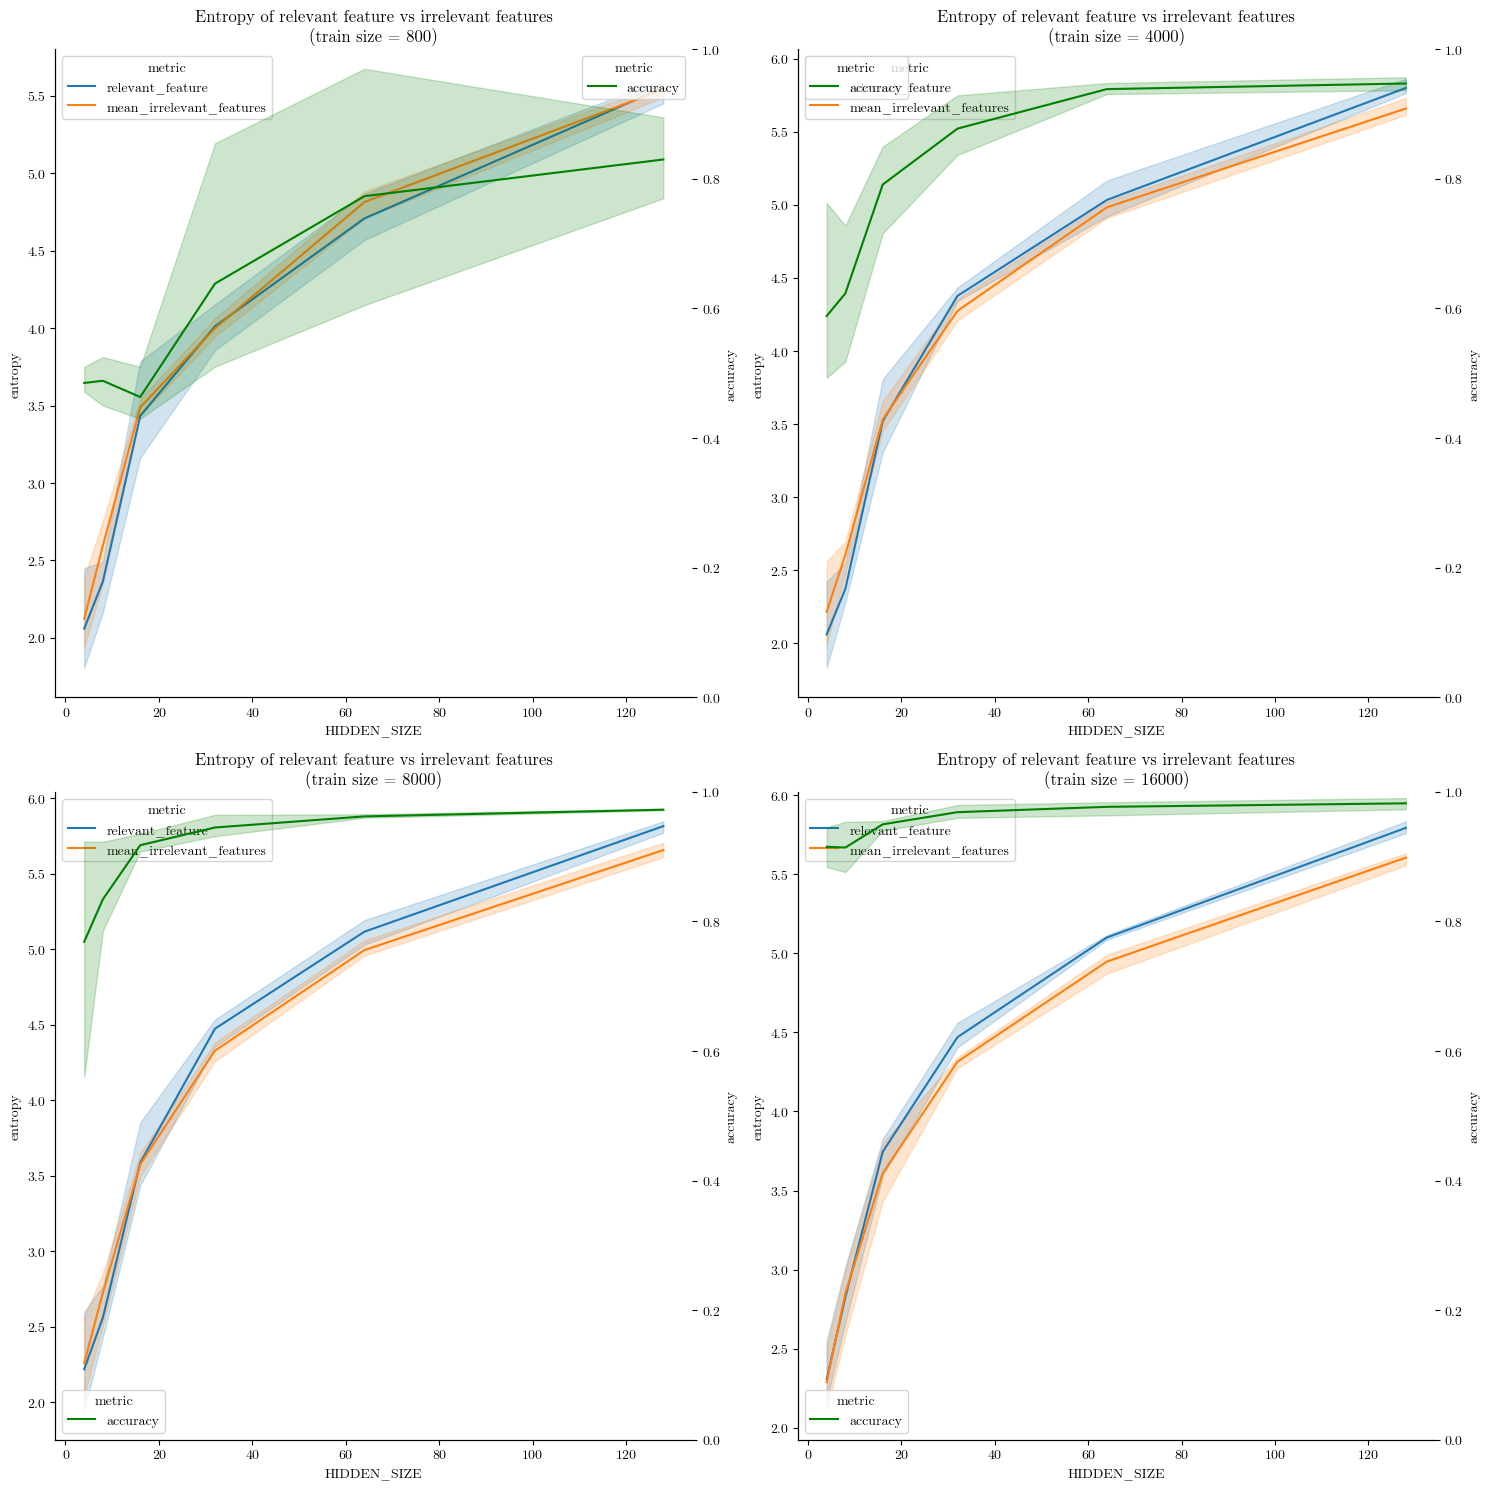

In [15]:
ds_sizes = sorted(expanded_df_long["num_points"].unique())
num_ds_sizes = len(ds_sizes)
print(num_ds_sizes)
fig, axes = plt.subplots(int(num_ds_sizes / 2), 2, figsize=(15, 15))
for i in range(num_ds_sizes):
    ds_size = ds_sizes[i]
    sns.lineplot(
        data=expanded_df_long[expanded_df_long["num_points"] == ds_size],
        x="HIDDEN_SIZE",
        y="entropy",
        hue="metric",
        ax=axes[int(i / 2)][int(i % 2)]
        # style="num_points",
    )
    ax2 = axes[int(i / 2)][int(i % 2)].twinx()
    sns.lineplot(
        data=expanded_df_long_accuracy[
            expanded_df_long_accuracy["num_points"] == ds_size
        ],
        x="HIDDEN_SIZE",
        y="accuracy",
        hue="metric",
        ax=ax2,
        palette=["g"]
        # style="num_points",
    )
    ax2.set_ylim((0.0, 1.0))

    axes[int(i / 2)][int(i % 2)].set_title(
        f"Entropy of relevant feature vs irrelevant features\n(train size = {int(ds_size * 0.8)})"
    )
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats.png"))
wandb.log(
    {
        "plot": wandb.Image(
            os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats.png")
        )
    }
)

4


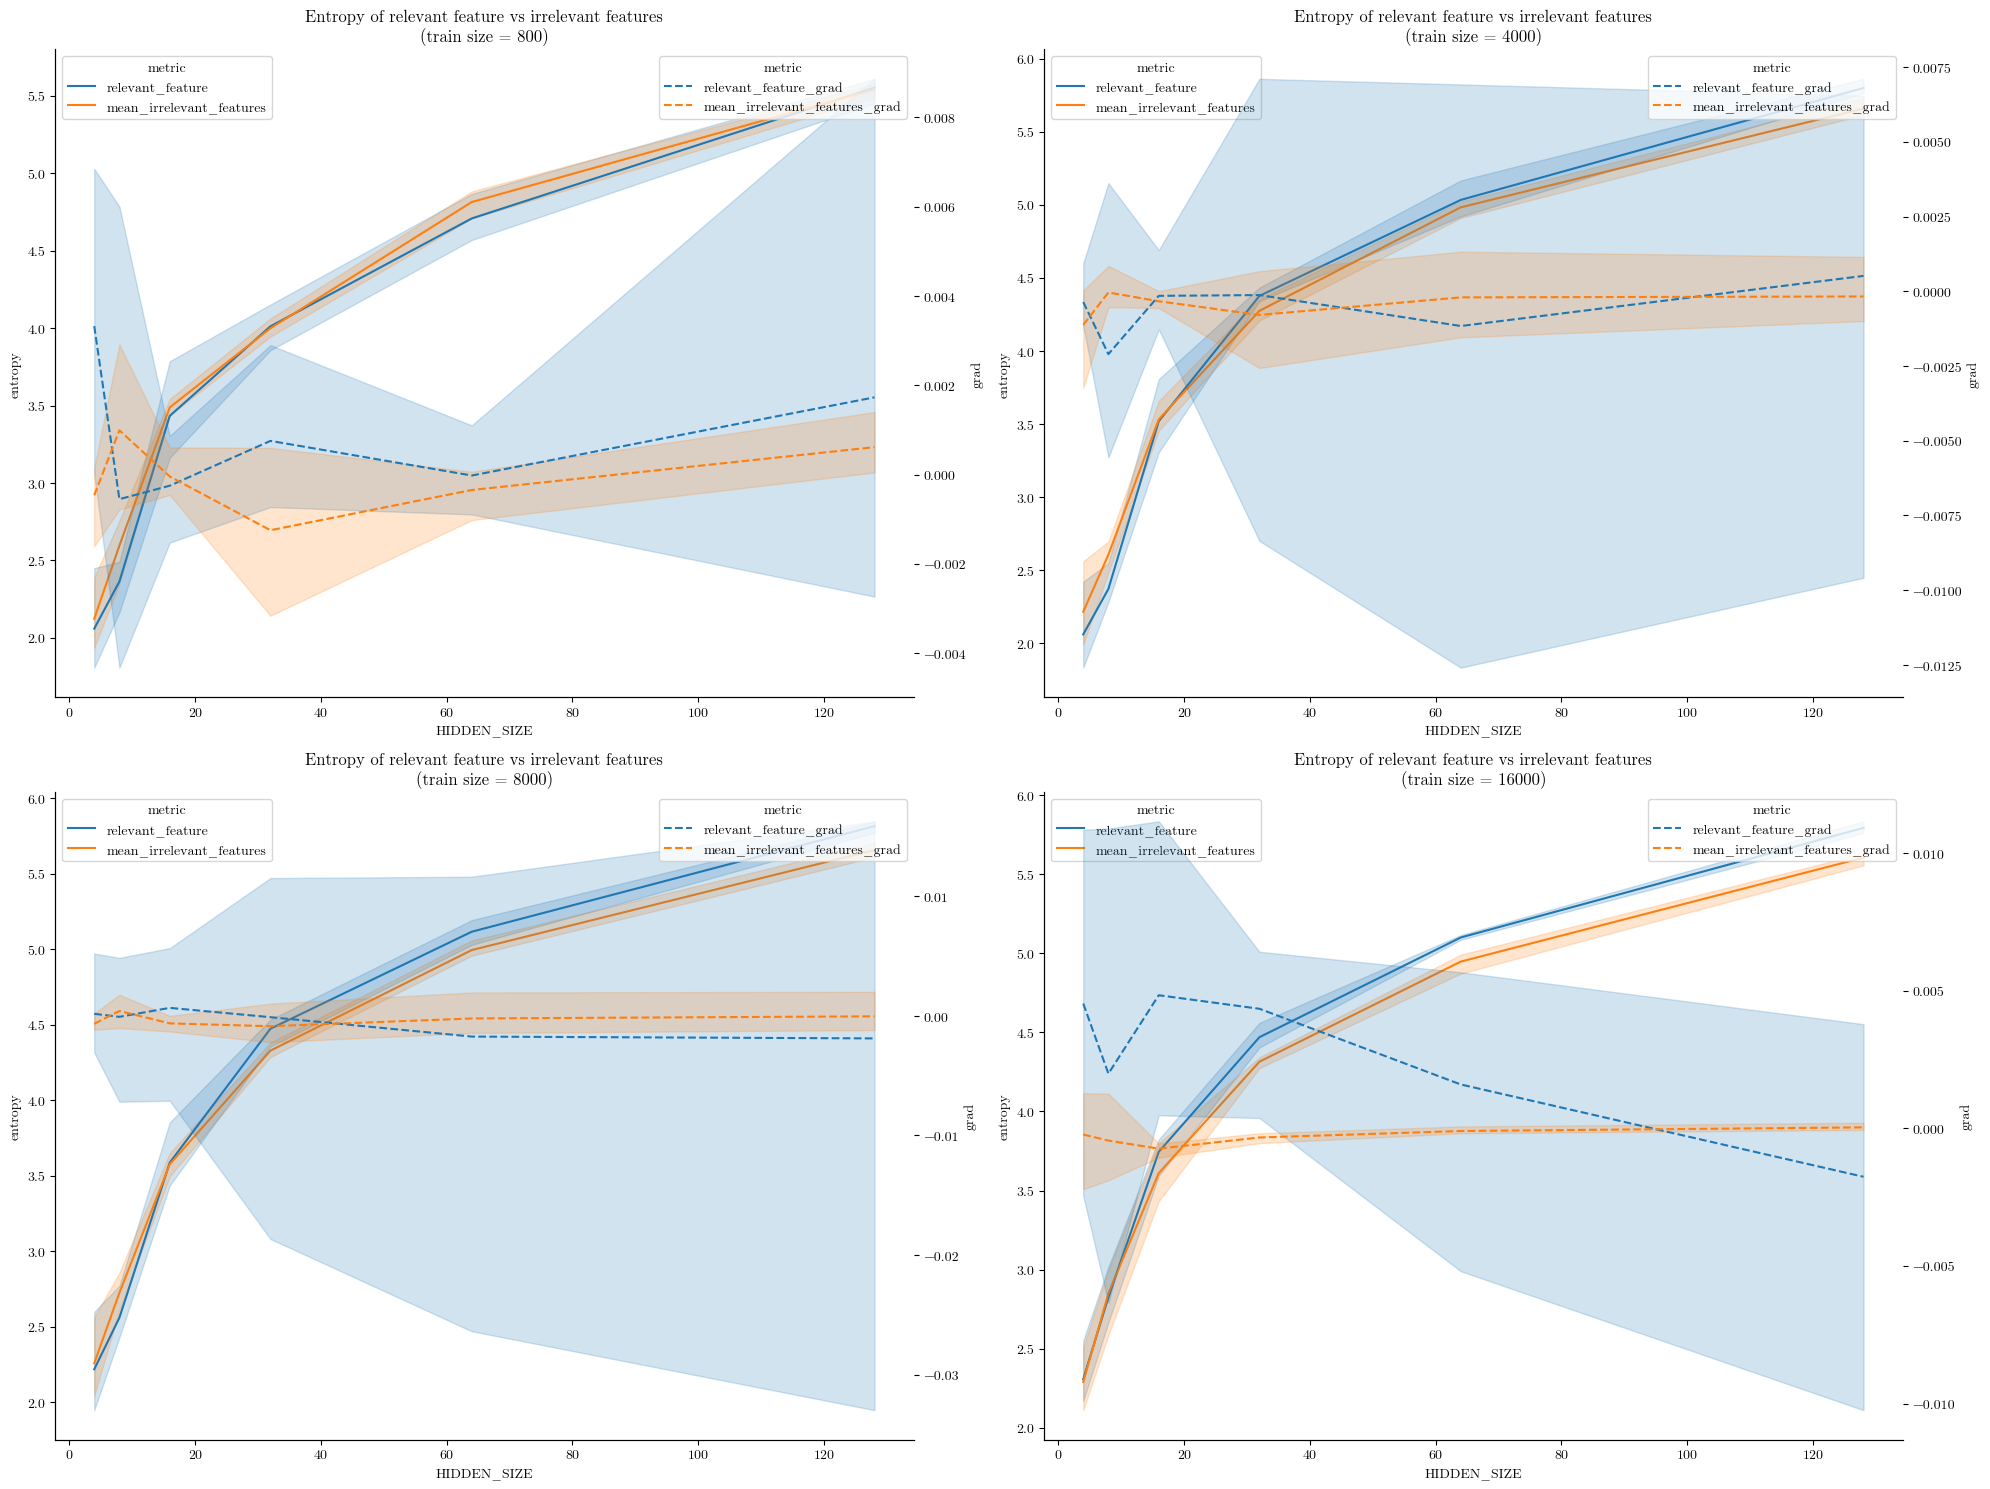

In [16]:
ds_sizes = sorted(expanded_df_long["num_points"].unique())
num_ds_sizes = len(ds_sizes)
print(num_ds_sizes)
fig, axes = plt.subplots(int(num_ds_sizes / 2), 2, figsize=(20, 15))
for i in range(num_ds_sizes):
    ds_size = ds_sizes[i]
    sns.lineplot(
        data=expanded_df_long[expanded_df_long["num_points"] == ds_size],
        x="HIDDEN_SIZE",
        y="entropy",
        hue="metric",
        ax=axes[int(i / 2)][int(i % 2)]
        # style="num_points",
    )
    ax2 = axes[int(i / 2)][int(i % 2)].twinx()
    sns.lineplot(
        data=expanded_df_long_grads[expanded_df_long_grads["num_points"] == ds_size],
        x="HIDDEN_SIZE",
        y="grad",
        hue="metric",
        ax=ax2,
        linestyle="dashed"
        # style="num_points",
    )
    leg = ax2.get_legend()
    [ll.set_linestyle("--") for ll in leg.get_lines()]

    axes[int(i / 2)][int(i % 2)].set_title(
        f"Entropy of relevant feature vs irrelevant features\n(train size = {int(ds_size * 0.8)})"
    )
plt.tight_layout()

plt.savefig(os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats_w_grads.png"))
wandb.log(
    {
        "plot": wandb.Image(
            os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats_w_grads.png")
        )
    }
)

In [17]:
palette = sns.color_palette("coolwarm", 8)
palette = palette[0:1] + palette[-1:]
print([mpl.colors.to_hex(c) for c in palette])
sns.set_palette(palette)
palette

['#5d7ce6', '#d95847']


[(0.3634607953411765, 0.4847836818509804, 0.9010188868941177),
 (0.8523781350078431, 0.34649194649411763, 0.2803464686980392)]

In [18]:
expanded_df_long[expanded_df_long["num_points"] == ds_size]

,HIDDEN_SIZE,num_points,metric,entropy
0,128.0,20000.0,relevant_feature,5.759920
1,64.0,20000.0,relevant_feature,5.098937
2,32.0,20000.0,relevant_feature,4.560669
3,16.0,20000.0,relevant_feature,3.592794
4,8.0,20000.0,relevant_feature,2.793305
5,4.0,20000.0,relevant_feature,2.552239
6,128.0,20000.0,relevant_feature,5.784768
7,64.0,20000.0,relevant_feature,5.115720
8,32.0,20000.0,relevant_feature,4.443542
9,16.0,20000.0,relevant_feature,3.816322


In [19]:
font = {
    # "family": "normal",
    # "weight": "bold",
    "size": 17,
    # "family": "serif",
    # "serif": ["Computer Modern"],
}
plt.rc("font", **font)

4


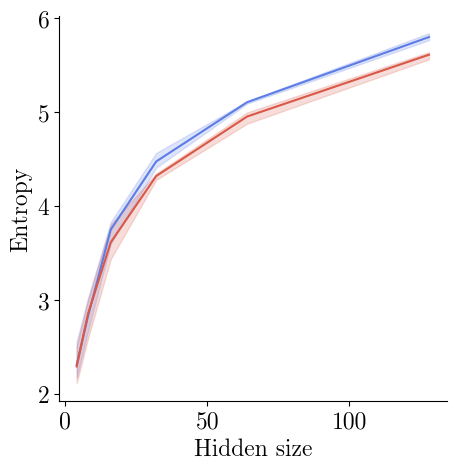

In [20]:
ds_size = ds_sizes[-1]
print(num_ds_sizes)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

use_legend = False
sns.lineplot(
    data=expanded_df_long[expanded_df_long["num_points"] == ds_size],
    x="HIDDEN_SIZE",
    y="entropy",
    hue="metric",
    ax=ax,
    legend=use_legend,
    # style="num_points",
)
linecolors = [l.get_color() for l in ax.get_lines()]

# offset = 0.17
# fig.text(
#     0.3 + offset,
#     0.95,
#     "Entropy vs model complexity\n ",
#     ha="center",
#     va="bottom",
#     size="large",
#     color="black",
# )
# offset2 = 0.1
# fig.text(
#     0.0 + offset2,
#     0.95,
#     "(for  ",
#     ha="center",
#     va="bottom",
#     size="large",
#     color="black",
# )
# fig.text(
#     0.16 + offset2,
#     0.95,
#     "relevant ",
#     ha="center",
#     va="bottom",
#     size="large",
#     color=linecolors[0],
# )
# fig.text(
#     0.3 + offset2,
#     0.95,
#     "& ",
#     ha="center",
#     va="bottom",
#     size="large",
#     color="black",
# )
# fig.text(
#     0.45 + offset2,
#     0.95,
#     "irrelevant",
#     ha="center",
#     va="bottom",
#     size="large",
#     color=linecolors[1],
# )
# fig.text(
#     0.695 + offset2,
#     0.95,
#     "features)",
#     ha="center",
#     va="bottom",
#     size="large",
#     color="black",
# )

ax.set_xlabel("Hidden size")
ax.set_ylabel("Entropy")
# plt.tight_layout()
plt.savefig(
    os.path.join(
        SAVE_DIR,
        f"entropy_relevant_vs_irrelevants_feats_only_{int(ds_size * 0.8)}.pdf",
    ),
    bbox_inches="tight",
)
# wandb.log(
#     {
#         "plot": wandb.Image(
#             os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats_w_grads.png")
#         )
#     }
# )

In [21]:
wandb.finish()